<a href="https://colab.research.google.com/github/erl-j/various-colab-notebooks/blob/main/cross_modal_music_mood_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross modal music mood search

Welcome! In this notebook, we query the [Jamendo MTG dataset](https://github.com/MTG/mtg-jamendo-dataset) with text/images using mood vectors as the bridge between the text/images and music domains. 

First, we use a [zero shot text classification pipeline from the transformers library](https://discuss.huggingface.co/t/new-pipeline-for-zero-shot-text-classification/681) to convert our text to a mood vector. If we are starting from an image we instead use [CLIP](https://huggingface.co/transformers/model_doc/clip.html). 

Then, we use some distance measure (l1, l2 or cos) to find the tracks whose moods best matches our mood vector.

In [ ]:
#@title Download dependencies
# download jamendo data
%%capture
!wget https://raw.githubusercontent.com/MTG/mtg-jamendo-dataset/master/data/autotagging_moodtheme.tsv
!pip install transformers plotext sklearn pandas seaborn

In [ ]:
#@title Imports & initialize text classifier
import time
import pandas as pd
import numpy as np
import plotext as plt
from transformers import pipeline
import sklearn as skl
import sklearn.preprocessing, sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

classifier = pipeline("zero-shot-classification")

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
#@title Load track data
# read weird tsv
with open("autotagging_moodtheme.tsv","r") as f:
    lines = f.read().splitlines()

items  = [ l.split() for l  in lines]
header_items = items[0]
rows=items[1:]
n_colums = len(header_items)
records = [{header_items[col_idx]:rows[row_idx][col_idx] for col_idx in range(n_colums-1)} for row_idx in range(len(rows))]
records = [{**records[row_idx],"moods":rows[row_idx][n_colums-1:]} for row_idx in range(len(rows))]

# cleanup remove "mood/theme---"- prefix from moods
records =  [{**r,"moods":[mood.replace("mood/theme---","") for mood in r["moods"]]}for r in records]

# convert to pandas dataframe
df = pd.DataFrame.from_dict(records)

# load mood list and multihot encode track-moods

MOODS=[
"action",
"adventure",
"advertising",
"ambiental",
"background",
"ballad",
"calm",
"children",
"christmas",
"commercial",
"cool",
"corporate",
"dark",
"deep",
"documentary",
"drama",
"dramatic",
"dream",
"emotional",
"energetic",
"epic",
"fast",
"film",
"fun",
"funny",
"game",
"groovy",
"happy",
"heavy",
"holiday",
"hopeful",
"horror",
"inspiring",
"love",
"meditative",
"melancholic",
"mellow",
"melodic",
"motivational",
"movie",
"nature",
"party",
"positive",
"powerful",
"relaxing",
"retro",
"romantic",
"sad",
"sexy",
"slow",
"soft",
"soundscape",
"space",
"sport",
"summer",
"trailer",
"travel",
"upbeat",
"uplifting"]

mood_binarizer= skl.preprocessing.MultiLabelBinarizer(classes=MOODS)
df["moods_multihot"]=mood_binarizer.fit_transform(df["moods"]).tolist()

TRACK_DF=df


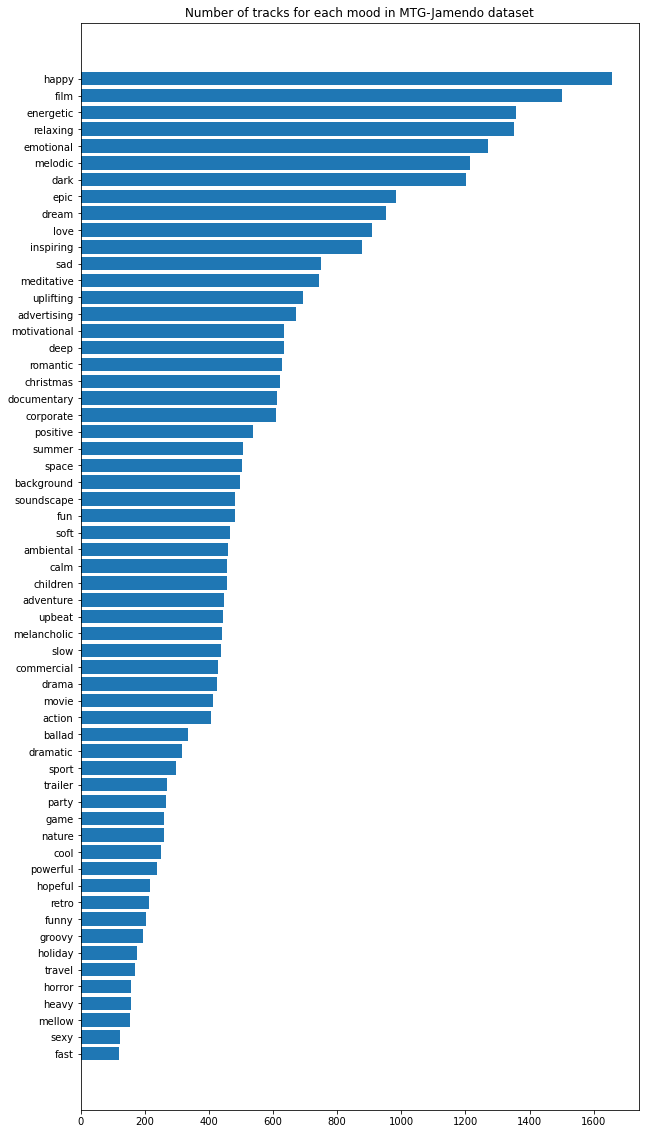

In [ ]:
#@title Display occurences of each mood
# show track mood distribution
track_mood_matrix=np.array(TRACK_DF["moods_multihot"].values.tolist())

mood_sums = np.sum(track_mood_matrix,axis=0)

mood2sum = [[name,value] for name,value in zip(MOODS,mood_sums)]

mood_order=np.argsort(mood_sums)

plt.rcParams["figure.figsize"] = (10,20)
fig, ax = plt.subplots()
ax.barh(y=range(len(MOODS)),width=mood_sums[mood_order],tick_label=np.array(MOODS)[mood_order])
ax.set_title("Number of tracks for each mood in MTG-Jamendo dataset")
plt.show()

# plot coccurence matrix
coocurence_matrix=np.zeros((len(MOODS),len(MOODS)))

for m in range(track_mood_matrix.shape[1]):
  coocurence_matrix[m,:] = np.sum(track_mood_matrix[:,m][:,None]*track_mood_matrix,axis=0)

coocurence_matrix = coocurence_matrix*(1-np.identity(len(MOODS)))

#sns.heatmap(coocurence_matrix)
#plt.show()

In [ ]:
#@title Define plotting & track retrieval fns

def plot_moods(mood):
  # order scores
  mood=mood[None,:]

  argsort = np.argsort(-mood)[0]

  score_order=mood[0][argsort]
  mood_order=np.array(MOODS)[argsort]

  # plot mood weights
  plt.rcParams["figure.figsize"] = (10,3)
  N_MOODS_IN_PLOT=10
  fig, ax = plt.subplots()
  ax.barh(y=range(N_MOODS_IN_PLOT),width=score_order[:N_MOODS_IN_PLOT],tick_label=mood_order[:N_MOODS_IN_PLOT])
  ax.invert_yaxis() 
  ax.set_title(f"Top {N_MOODS_IN_PLOT} mood scores")
  plt.show()

def mood2tracks(mood,metric="l1"):
  mood=mood[None,:]
  
  # extract and normalize track mood matrix
  track_mood_matrix=np.array(TRACK_DF["moods_multihot"].values.tolist())

  # normalize by mood frequency
  #track_mood_matrix= track_mood_matrix/np.log(np.sum(track_mood_matrix,axis=0)[None,:])

  # normalize by number of mood tags
  track_mood_matrix = track_mood_matrix/np.sum(track_mood_matrix,axis=1)[:,None]

  N_RESULTS=5

  distances=skl.metrics.pairwise_distances(mood,track_mood_matrix,metric=metric)[0]
  top_track_idx = np.argsort(distances)    
  top_10_track_idx = top_track_idx[:N_RESULTS].tolist()

  i=1
  print("Results from Jamendo dataset:")
  for idx,row in TRACK_DF.iloc[top_10_track_idx].iterrows():
    print(f"Result nr {i}:")
    print("Theme/Mood-tags:")
    print(row["moods"])
    print(f"https://www.jamendo.com/track/{row['TRACK_ID'].replace('track_','')}")
    print("\n")
    
    i+=1
  return 


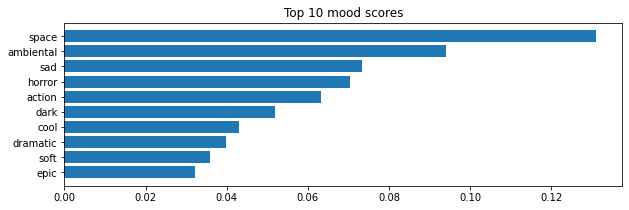

Results from Jamendo dataset:
Result nr 1:
Theme/Mood-tags:
['dark', 'sad', 'space']
https://www.jamendo.com/track/1304477


Result nr 2:
Theme/Mood-tags:
['sad', 'space']
https://www.jamendo.com/track/0579312


Result nr 3:
Theme/Mood-tags:
['sad', 'space']
https://www.jamendo.com/track/1014400


Result nr 4:
Theme/Mood-tags:
['sad', 'space']
https://www.jamendo.com/track/0935513


Result nr 5:
Theme/Mood-tags:
['sad', 'space']
https://www.jamendo.com/track/0997872




In [ ]:
#@title Text 2 Mood 2 Tracks

# define distances

def text2mood(text):
  # run text mood classification
  res = classifier(text, MOODS)
  text_mood = np.zeros((len(MOODS)))

  for label,score in zip(res["labels"],res["scores"]):
      text_mood[MOOD2IDX[label]]=score

  return text_mood

MOOD2IDX = {m:i for i,m in enumerate(MOODS)}

text = 'The body is in the garage' #@param {type:"string"}
metric = 'cosine' #@param ["l1", "l2", "cosine"]

mood=text2mood(text)
plot_moods(mood)
mood2tracks(mood,metric)

(1306, 1328, 3)


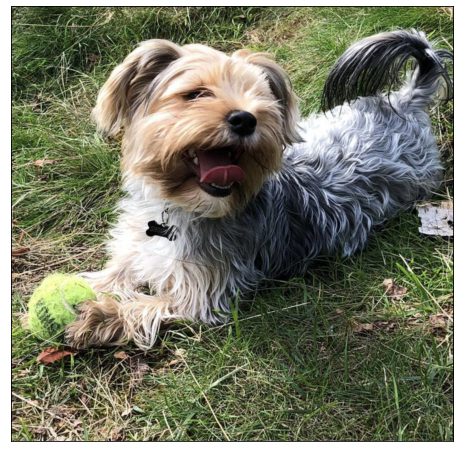

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


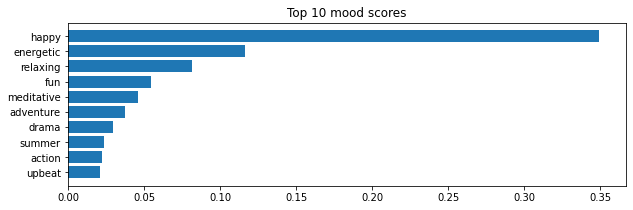

Results from Jamendo dataset:
Result nr 1:
Theme/Mood-tags:
['happy']
https://www.jamendo.com/track/1089925


Result nr 2:
Theme/Mood-tags:
['happy']
https://www.jamendo.com/track/1341464


Result nr 3:
Theme/Mood-tags:
['happy']
https://www.jamendo.com/track/0095612


Result nr 4:
Theme/Mood-tags:
['happy']
https://www.jamendo.com/track/1401593


Result nr 5:
Theme/Mood-tags:
['happy']
https://www.jamendo.com/track/1222934




In [ ]:
#@title Image 2 Mood 2 Tracks

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

def image2mood(image):
  processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

  inputs = processor(text=MOODS, images=image, return_tensors="pt", padding=True)

  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image # this is the image-text similarity score
  probs = logits_per_image.softmax(dim=1).detach().numpy()[0] # we can take the softmax to get the label probabilities

  argsort=np.argsort(-probs)
  sorted_probs=probs[argsort]
  sorted_moods=np.array(MOODS)[argsort]
  return probs

image_url = "https://musaiclab.files.wordpress.com/2021/09/screenshot-2021-09-06-at-09.40.56.png" #@param {type:"string"}
metric = 'cosine' #@param ["l1", "l2", "cosine"]

image = Image.open(requests.get(image_url, stream=True).raw)
image=image.convert('RGB')
plt.rcParams["figure.figsize"] = (8,8)
fig, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.imshow(np.asarray(image))
plt.show()

mood=image2mood(image)
plot_moods(mood)
mood2tracks(mood,metric)

In [ ]:
#@title Bonus: mood 2 emoji for nice presentation

from PIL import Image, ImageFont, ImageDraw



